In [70]:
using Pkg

Pkg.activate(".")

using FoodWebs

fw = FoodWebs

using DifferentialEquations
using CairoMakie
using Combinatorics
using Random

Random.seed!(42)

  Activating project at `~/Projects/Working/HIFMB/reactivity`


TaskLocalRNG()

# Introduction

In this notebook i simulate some foodwebs with stochastic dynamics. The goal is to use these to infer partial jacobian matricies and show this sets a minimum bound on the reactivity of the whole foodweb. 

The code uses the julia `DifferentialEquations` package as well as the `Foodwebs` package I have written avalible on [github](https://github.com/CleggTom/FoodWebs.jl). To install this package you can simply enter the julia package manager and write

`add https://github.com/CleggTom/FoodWebs.jl`

# Generate communtity

First we generate the community using the code from the foodwebs package. This is basically generating a random web using the niche model. Then we use generalised modeling to determine the proportion of webs with which structure and randomly drawn parameter values (i.e. dynamics) are stable. This is repeated till we fins a web where over 95% of parameter values are stable indicating the structure is in some way inherently stable. 

In [71]:
#generate stable community
psw = 0.0

N = 10
    sp_vec = [fw.species(0.2) for i = 1:N]
    com = fw.community(sp_vec)

while psw < 0.02
    N = 25
    sp_vec = [fw.species(0.2) for i = 1:N]
    com = fw.community(sp_vec)
    psw = fw.proportion_stable_webs(com)
end

# N = 25
# sp_vec = [fw.species(0.3) for i = 1:N]
# com = fw.community(sp_vec)
# com = fw.stable_parameterisation(com)

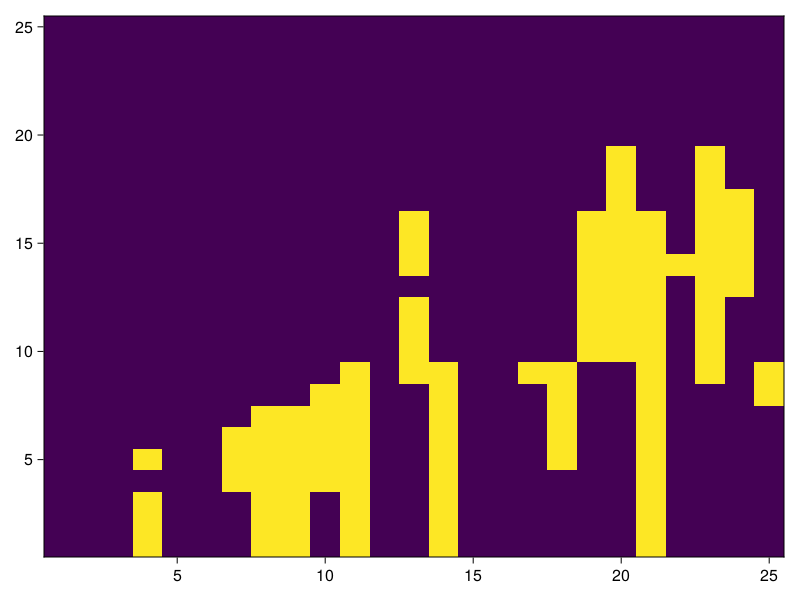

In [72]:
bs_index = sortperm(com.n)
heatmap(com.A[bs_index, bs_index])

## Motif search

Next we look for motifs matching the one discussed (three producers of which two share a single predator) in the web. we then save this to a vector of species indicies. 

In [73]:
#motif search
# look for triplets of producers where 2 share 1 predator
prod_index = findall(sum(com.A, dims = 2)[:] .== 0)
motifs = Vector{Vector{Int64}}()

#itterate through triplets
for i = Combinatorics.combinations(prod_index, 3)
    #itterate through sp
    for k = 1:size(com.A)[1]
        if k in prod_index
            continue
        end
        
        sub_mat = com.A[vcat(i,k),vcat(i,k)]
        n_links = sum(sub_mat)
        
        #two consumption links by predator means motif must match
        if n_links == 2
            motif_indx = vcat(i,k)
            push!(motifs,motif_indx) 
        end
    end
end

motifs

228-element Vector{Vector{Int64}}:
 [4, 5, 8, 11]
 [4, 5, 8, 16]
 [4, 5, 8, 19]
 [4, 5, 8, 20]
 [4, 5, 8, 21]
 [4, 5, 9, 6]
 [4, 5, 9, 12]
 [4, 5, 9, 15]
 [4, 5, 9, 17]
 [4, 5, 9, 23]
 [4, 5, 10, 11]
 [4, 5, 10, 16]
 [4, 5, 10, 20]
 ⋮
 [10, 13, 24, 23]
 [10, 14, 24, 2]
 [10, 14, 24, 6]
 [10, 14, 24, 7]
 [10, 14, 24, 12]
 [10, 14, 24, 15]
 [10, 14, 24, 18]
 [10, 14, 24, 23]
 [13, 14, 24, 2]
 [13, 14, 24, 7]
 [13, 14, 24, 17]
 [13, 14, 24, 18]

## Simulations

Now we have a network of interest we can simulate the dynamics. To do so we set up some simple foodweb dynamics with the general form:

\begin{align}
    \frac{dx_i}{dt} = f(x_i) - h(x_i) + \sum_j g(x_i,x_j)
\end{align}

where $f(x_i)$ is production, $g(x_i, x_j)$ is the interaction term and $h(x_i)$ is the mortality term. 


In [74]:
#Struct to hold parameterised functions for dynamics
#f: producer growth function
#g: interaction functions
#h: loss functions
struct FwParams{F <: Function, G <: Function, H <: Function}
    f::Vector{F} 
    g::Matrix{G}
    h::Vector{H}
    p_indx::Vector{Bool}
    N::Int64
end

#deterministic part of dynamics
function dx!(dx,x,p,t)
    for i = 1:p.N
        dx[i] = p.f[i](x[i]) - p.h[i](x[i])
        for j = 1:p.N
            dx[i] += p.g[i,j](x[i], x[j])
        end
        
        if (x[i] + dx[i]) < 0
            dx[i] = -x[i]
        # else
        #     # dx[i] = 1e-4 
        end 
    end
end

#stochastic part - sets the sd of stochastic variation
function dσ(dx,x,p,t)
    for i = 1:p.N
        # dx[i] = p.p_indx[i] && (x[i] > 0) ? 10.0 : 0.0
        dx[i] = 10rand()
    end
    # dx[1] = 10.0
end

dσ (generic function with 1 method)

## Sampling

Next we set up a sampler to faciliate creation of random communities with parameters. This is slight overkill but works nicely. Currently the parameters are set as:

\begin{align}
    f(x_i) &= r_i x_i \\
    g(x_i,x_j) &= a_{ij} x_i \frac{x_j}{x_j + k_{i,j}} \\
    h(x_i) &= u_i x_i^2
\end{align}

the parameters $r_i$, $a_{ij}$, $u_i$ are all drawn randomly.

In [75]:
using Random
import Random.rand
import Random.SamplerSimple

#define return type for random sampler
Random.eltype(::Type{fw.Community}) = FwParams

#use trivial sampler
function Random.Sampler(::Type{<:AbstractRNG}, p::fw.Community, ::Random.Repetition)
    Random.SamplerTrivial(p)
end

#define actual sampling
function rand(rng::AbstractRNG, p::Random.SamplerTrivial{fw.Community})
    N = size(p[].A)[1]
    
    producers = Vector(sum(p[].A, dims = 2)[:] .== 0)
    apex_pred = sum(p[].A, dims = 1) .== 0
    
    
    r = zeros(N) #growth rates
    a = zeros(N,N) #interaction strengths
    k = zeros(N,N) #half-saturation constants
    u = zeros(N) #mortality
    
    #draw parameters
    for i = 1:N
        r[i] = producers[i] ? rand() : 0.0
        u[i] = (producers[i] | apex_pred[i]) ? 1.0 : 0.1
        for j = 1:N
            if p[].A[i,j] == 1
                a[i,j] = p[].A[i,j]
                a[j,i] = -p[].A[i,j]
                k[i,j] = k[j,i] = rand()
            end
        end
    end
    
    f = Vector{Function}(undef, N)
    g = Matrix{Function}(undef, N, N)
    h = Vector{Function}(undef, N)
    
    for i = 1:N
        f[i] = x -> r[i] * x
        h[i] = x -> u[i] * x^2  
        for j = 1:N
            if a[i,j] > 0
                g[i,j] = (x,y) -> a[i,j] * x * y / (y + k[i,j])
            elseif a[i,j] < 0
                g[i,j] = (x,y) -> a[j,i] * x * y / (x + k[i,j])
            else
                g[i,j] = (x,y) -> 0.0
            end
            
        end
    end
    
    #Convert to functions
    # f = [x -> r[i] * x * producers[i] for i = 1:N]
    # g = [(x,y) -> a[i,j]* x * y / (1 + y)  for i = 1:N, j = 1:N]
    # h = [x -> u[i] * x * x for i = 1:N]
    
    return(FwParams(f,g,h,producers,N))
end

rand (generic function with 236 methods)

## Sampling and simulation

Finally we simulate the community first generating using the defined `rand` command and then using the SDE solver.

In [76]:
 p = rand(com);

In [77]:
u0 = rand(p.N) 
tspan = (0.0, 1e3)
prob = SDEProblem(dx!,dσ, u0, tspan, p)

dt = 1 // 2^(4)
cb = PositiveDomain()

sol = solve(prob, EM(), isoutofdomain=(y,p,t)->any(x->x<0,y), dt = dt);

### Saving

If you want to export the timeseries you can just access the whole matrix using the solution object

In [81]:
using DelimitedFiles

t_vec = range(50, 100, length = 1000)
sol_mat = hcat(sol.(t_vec)...)
#time series
writedlm("./stoch_ts.csv", sol_mat, ',')
#interaction matrix
writedlm("./int_mat.csv", com.A, ',')
#motifs
writedlm("./motifs.csv", hcat(motifs...), ',')

4×228 Matrix{Int64}:
  4   4   4   4   4  4   4   4   4   4  …  10  10  10  10  10  13  13  13  13
  5   5   5   5   5  5   5   5   5   5     14  14  14  14  14  14  14  14  14
  8   8   8   8   8  9   9   9   9   9     24  24  24  24  24  24  24  24  24
 11  16  19  20  21  6  12  15  17  23      7  12  15  18  23   2   7  17  18

### Plotting

Here I plot the dyanmics (ignoring the "burn in" phase) with one of the motifs coloured in red. 

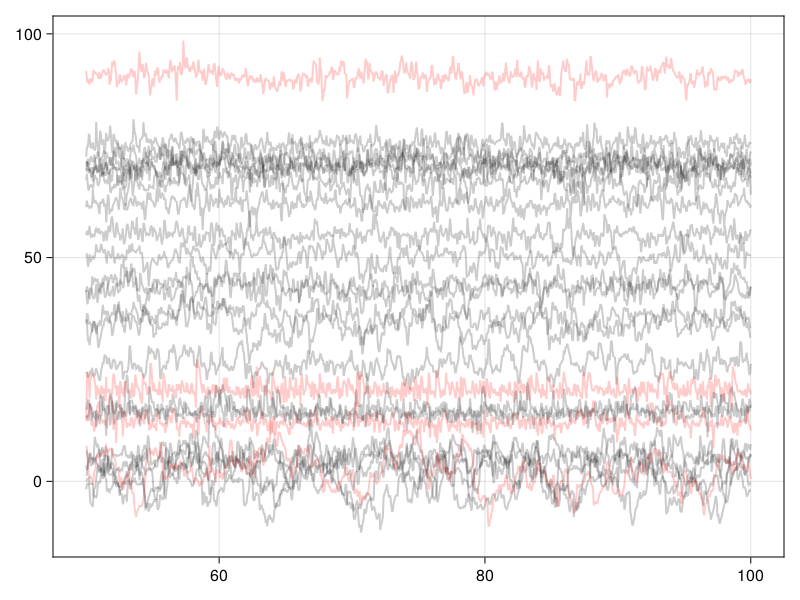

In [69]:
fig = Figure()
ax = Axis(fig[1,1])

# color producers
producers = findall(sum(com.A, dims = 2) .== 0)

#color motif
motif_col = motifs[1]

col = fill((:black,0.2), com.N)
# col[producers] .= Ref((:blue, 0.2))
col[motif_col] .= Ref((:red, 0.2))

t_vec = range(50, 100, length = 1000)

series!(ax, t_vec, hcat(sol.(t_vec)...), color = col)

fig

### Derivative correlations

here I plot the derivtives of the populations in the motif against each other. Correlations here should correspond to the entries in the jaccobian matrix

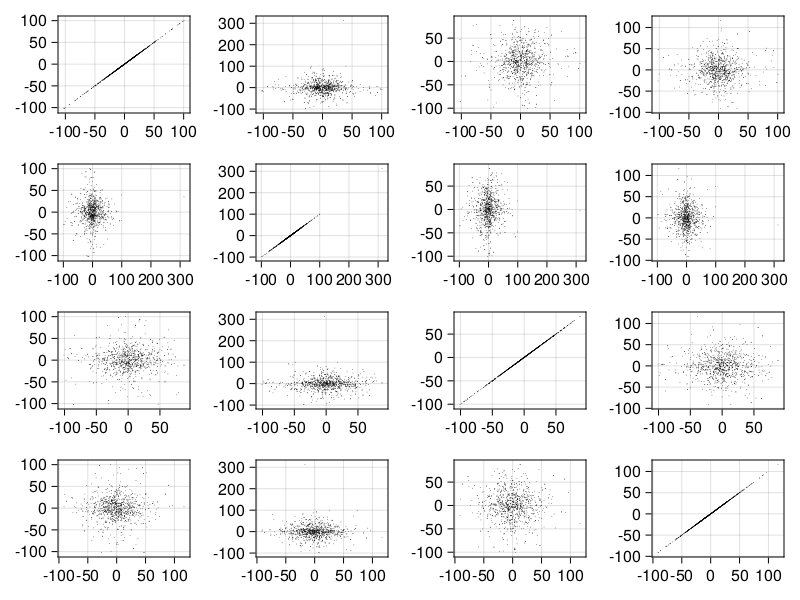

In [180]:
# x = sol(t_vec[1:end], Val{0})[motif_col,:]
dx = sol(t_vec[1:end], Val{1})[motif_col,:]

fig = Figure()
ax = Array{Axis,2}(undef,4,4)

for i = 1:4
    for j = 1:4
        ax[i,j] = Axis(fig[i,j])
        plot!(ax[i,j], dx[i,:], dx[j,:],markersize = 1.0)
    end
end

fig